![Sentiment Analysis](Customer-survey-feedback.jpg)

# Problem Statement 
The lack of comprehensive understanding of public sentiment towards Google and Apple brands presents a significant challenge for our tech firm specializing in these companies' products. By analyzing customer feedback expressed on Twitter, we aim to identify specific areas for improvement in Google and Apple products and services. Ultimately, this analysis will empower **Best Buy** to make strategic decisions that enhance customer satisfaction and bolster the market competitiveness of both Google and Apple products.
In today's digital age, social media platforms like Twitter serve as a valuable source of public opinion and customer feedback, offering insights that can drive strategic decision-making for businesses.

As a consulting firm commissioned by Best Buy, our objective is to develop a robust model capable of analyzing tweet content to accurately assess sentiment towards Apple and Google products. This model will effectively categorize tweets into positive, negative, or neutral sentiments, providing valuable insights into public perception. These insights will be utilized to inform strategic business decisions and enhance customer satisfaction across enterprises in **Best Buy**. Additionally, the marketing team can leverage these insights to gauge public sentiment towards Apple and Google products on social media. By analyzing tweets, they can understand how customers perceive these brands and their products, identify areas for improvement, and capitalize on positive sentiment for targeted marketing campaigns.

# Objectives
1. **Understanding Public Opinion:** 
    Gain insights into public sentiment towards Google and Apple brands as discussed on Twitter.
2. **Customer Feedback Analysis:** 
    Analyze customer feedback expressed on Twitter to identify areas for improvement for Google and Apple products and services and enhance customer satisfaction.
3.  **Market Research:** 
    Use sentiment analysis to gather market intelligence, understand consumer preferences, and identify emerging trends in real-time. 
4. **Competitive Analysis:** 
    Compare the sentiment surrounding Google and Apple brands, as competitors, to inform strategic decision-making.

In [71]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import re
from string import punctuation

#scipy
from scipy.sparse import csr_matrix

#sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder

#xgboost
import xgboost as xgb

#nlkt
from nltk import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [2]:
# Define color map for plots
# Import color map
import matplotlib.cm as cm
# Choose a predefined colormap
colormap = cm.coolwarm  # Choose a diverging colormap like 'coolwarm', 'RdBu', 'seismic', etc.

# Create a color array with a range of colors from the chosen colormap
color_array = [colormap(i) for i in range(20)]  # Choose 20 colors from the palette

# Set the default color cycle to the color array
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_array)

In [3]:
# Load data and check structure 
data = pd.read_csv('data/judge_1377884607_tweet_product_company.csv')
data

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive emotion
8717,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
8718,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
8719,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [4]:
# Checking data structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


# Data Cleaning

In [5]:
# Check missing values
data.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5552
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [6]:
# Checking index of missing value in tweet column
data[data['tweet_text'].isna()].index

Index([6], dtype='int64')

In [7]:
# Dropping the row above
data.drop(index=data[data['tweet_text'].isna()].index, inplace= True)

In [8]:
# Change column names to shorten long column names
data.columns = ['tweet', 'brand_product', 'emotion']

In [9]:
# Change 'No emotion toward brand or product' to 'Neutral emotion'
data.loc[data['emotion'] == 'No emotion toward brand or product', 'emotion'] = 'Neutral'
data.loc[data['emotion'] == 'Positive emotion', 'emotion'] = 'Positive'
data.loc[data['emotion'] == 'Negative emotion', 'emotion'] = 'Negative'

In [10]:
# Checking value counts for brand_product column
data.brand_product.value_counts()

brand_product
iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: count, dtype: int64

In [11]:
# Derive 'brand_product' from tweets to fill missing values in former column
categories = np.array(['iPad', 'Apple', 'iPad', 'iPhone', 'Google', 'Android'])
def fill_missing_brand_product(df, categories):
    for i, row in df.iterrows():
        if pd.isnull(row['brand_product']):
            for category in np.concatenate((categories, np.char.lower(categories))):
                if category in row['tweet']:
                    # Use .loc[] to assign values to DataFrame
                    data.loc[i, 'brand_product'] = category
                    break  # Break out of inner loop once a category is found
                    
                    
# Call the function and pass the DataFrame 'data' and 'categories'
fill_missing_brand_product(data, categories)

In [12]:
# Check missing values, again
data.isna().sum()

tweet              0
brand_product    787
emotion            0
dtype: int64

In [13]:
# Percentage missing data for brand_product column
787/len(data)

0.09025229357798165

In [14]:
# Drop rows with missing data
data.dropna(inplace= True)
data

,tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive
...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive
8717,"Wave, buzz... RT @mention We interrupt your re...",google,Neutral
8718,"Google's Zeiger, a physician never reported po...",Google,Neutral
8719,Some Verizon iPhone customers complained their...,iPhone,Neutral


In [15]:
# Check for duplicate entries
data.duplicated().sum()

20

In [16]:
#Remove duplicates
data.drop_duplicates(inplace=True)

emotion
Neutral         4381
Positive        2845
Negative         543
I can't tell     144
Name: count, dtype: int64


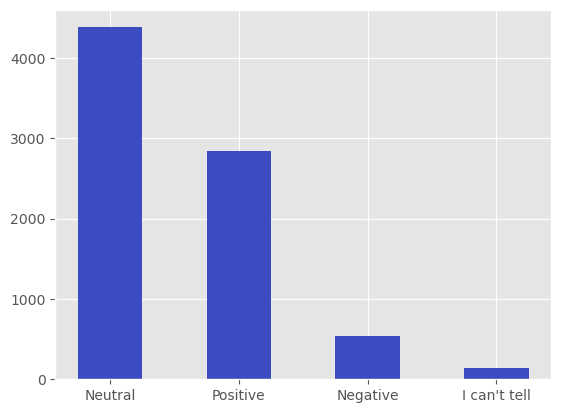

In [17]:
# Check classes for target feature
print(data.emotion.value_counts())
plt.bar(data.emotion.value_counts().index, data.emotion.value_counts(), width=.5);

In [18]:
# Drop rows where emotion is 'I can't tell'
data.drop(index=data[data['emotion'] == 'I can\'t tell'].index, inplace= True)
data.reset_index(drop=True, inplace=True)
data

,tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive
...,...,...,...
7764,Ipad everywhere. #SXSW {link},iPad,Positive
7765,"Wave, buzz... RT @mention We interrupt your re...",google,Neutral
7766,"Google's Zeiger, a physician never reported po...",Google,Neutral
7767,Some Verizon iPhone customers complained their...,iPhone,Neutral


In [19]:
# drop index 7768 with wierd characters
data.drop(index=7768, inplace= True)

In [20]:
# View full text on sample tweets
data[['tweet']].sample(10).style.set_properties(**{'text-align': 'left'})

,tweet
224,My iPhone app screen for #sxsw what am I missing? {link}
1752,@mention Apple to open a pop-up store downtown Austin (6th & congress) for #SXSW and the iPad 2 launch
6956,@mention strikes a pose & hopes to win an iPad. #sxsw {link}
2183,"Apple heads to SXSW, sets up temporary store in Austin {link} #Apple #iPad2 #RanceWilemon #SXSW #WhetherApple"
1665,Google analytics rocks #VIEW512 #SXSW
7146,Guy gets tattoo at SXSW so he could win a free iPad2 {link} #sxsw #tattoo #ipad #internet
1168,Lynn Teo - New Nav Schemas for iPad {link} #SXSW #UXDes
6268,Google showing preview of next-gen Blogger interface at #SXSW {link} #cnet
5138,RT @mention Hey @mention do you have an iPhone? We'd love to turn your art into a iPhone case. Let us know! #zazzlesxsw #sxsw
1672,Marissa & the Google crew recommend Amy's Ice Cream in Austin #SxSW


# Train test split

In [21]:
X = data[['tweet', 'brand_product']]
y = data['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 1)
X_train

,tweet,brand_product
4226,"In the Google keynote, Marissa Meyer and some ...",Google
5953,RT @mention Who is flying to #SXSW and wants s...,iPhone
2532,Ha! Another mention for Apple Store: {link} - ...,Apple
2481,;-) RT @mention @mention The geeks need somewh...,iPad
2652,This stuff is great. Love seeing how these guy...,Other Google product or service
...,...,...
905,Love it . RT @mention From #Apple to Naomi Cam...,Apple
5192,RT @mention I hope everyone has an awesome wee...,Apple
3980,Apple Opening Pop-Up Store in Austin (Sixth &a...,iPad
235,"#technews Apple heads to SXSW, sets up tempora...",iPad


# Data preprocessing

In [22]:
# Function to remove tweet handles(words that start with @), HTML tags and URLs in tweets
def remove_html_urls_mentions(input_text):
    # Remove HTML tags
    pattern_html = re.compile('<.*?>')
    text_without_html = pattern_html.sub(r'', input_text)
    
    # Remove URLs
    text_without_urls = re.sub(r"http\S+|www\S+|https\S+", "", text_without_html)
    
    # Remove Twitter usernames (mentions)
    text_without_mentions = re.sub(r'@\w+\s*', '', text_without_urls)
    
    return text_without_mentions

In [23]:
# Function to encode emojis
def encode_emojis(text):
    """
    Encode emojis in text using Unicode.

    Parameters:
    text (str): Input text containing emojis.

    Returns:
    str: Text with emojis encoded using Unicode.
    """
    # Encode emojis using Unicode escape sequences
    emoji_encoded_text = text.encode('unicode-escape').decode('utf-8')
    
    return emoji_encoded_text

In [24]:
# Remove tweet handles(words that start with @), HTML tags and URLs in tweets, and encode emojis
X_train['cleaned_tweet'] = X_train['tweet'].apply(lambda text: encode_emojis(remove_html_urls_mentions(text)))
X_train = X_train[['tweet', 'cleaned_tweet', 'brand_product']].copy()
X_train

,tweet,cleaned_tweet,brand_product
4226,"In the Google keynote, Marissa Meyer and some ...","In the Google keynote, Marissa Meyer and some ...",Google
5953,RT @mention Who is flying to #SXSW and wants s...,RT Who is flying to #SXSW and wants some free ...,iPhone
2532,Ha! Another mention for Apple Store: {link} - ...,Ha! Another mention for Apple Store: {link} - ...,Apple
2481,;-) RT @mention @mention The geeks need somewh...,;-) RT The geeks need somewhere downtown to li...,iPad
2652,This stuff is great. Love seeing how these guy...,This stuff is great. Love seeing how these guy...,Other Google product or service
...,...,...,...
905,Love it . RT @mention From #Apple to Naomi Cam...,Love it . RT From #Apple to Naomi Campbell: po...,Apple
5192,RT @mention I hope everyone has an awesome wee...,RT I hope everyone has an awesome weekend at #...,Apple
3980,Apple Opening Pop-Up Store in Austin (Sixth &a...,Apple Opening Pop-Up Store in Austin (Sixth &a...,iPad
235,"#technews Apple heads to SXSW, sets up tempora...","#technews Apple heads to SXSW, sets up tempora...",iPad


## Exploratory Data Analysis

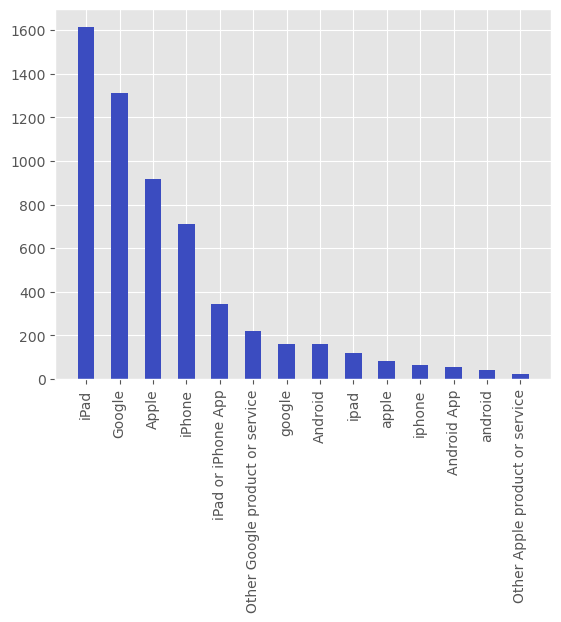

In [25]:
# EDA
X_train['brand_product'].value_counts()
plt.bar(X_train['brand_product'].value_counts().index, X_train['brand_product'].value_counts(), width=.5)
plt.xticks(rotation=90);

In [26]:
# Merge regarding into only two categories: apple and google brands
Apple = ['iPad', 'Apple', 'iPhone', 'iPad or iPhone App', 'ipad', 'apple', 'iphone', 'Other Apple product or service']
Google = ['Google', 'google', 'Other Google product or service', 'Android', 'Android App', 'android']

def brand_category(X):
    for index, row in X.iterrows():
        if row['brand_product'] in Apple:
            X.at[index, 'brand_product'] = 'Apple'
        elif row['brand_product'] in Google:
            X.at[index, 'brand_product'] = 'Google'
    
    return X

# Call function on X_train data
X_train = brand_category(X_train)

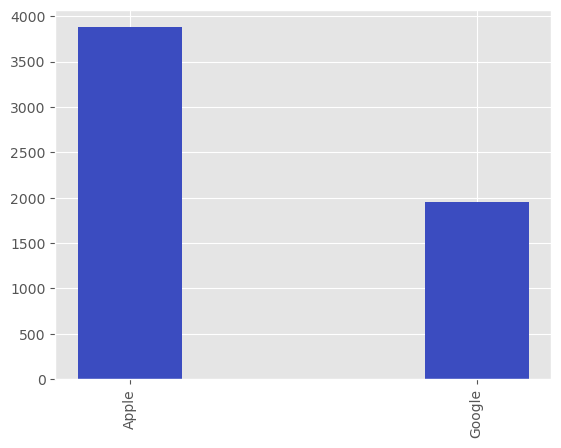

In [27]:
# Re-check brand_product column
X_train['brand_product'].value_counts()
plt.bar(X_train['brand_product'].value_counts().index, X_train['brand_product'].value_counts(), width=.3)
plt.xticks(rotation=90);

In [28]:
# Function to tokenize and remove stopwords and punctuation
def process_tweet(tweet):
    tweet = tweet.lower() #convert tweet to lowercase
    # Define a regular expression pattern to match words including apostrophes
    pattern = r"\b\w+(?:'\w+)?\b"
    # Create a RegexpTokenizer with the defined pattern
    tokenizer = RegexpTokenizer(pattern)
    # Tokenize tweet
    tokens = tokenizer.tokenize(tweet)
    tokens = [token for token in tokens if token not in stopwords.words('english') 
              and token not in punctuation]                                        #remove stopwords and punctuations
    return tokens

# Apply function
X_train['tokenized_tweets'] = X_train['cleaned_tweet'].apply(process_tweet)

In [29]:
# Change columns arrangement
X_train = X_train[['tweet', 'cleaned_tweet', 'tokenized_tweets', 'brand_product']]
X_train

,tweet,cleaned_tweet,tokenized_tweets,brand_product
4226,"In the Google keynote, Marissa Meyer and some ...","In the Google keynote, Marissa Meyer and some ...","[google, keynote, marissa, meyer, guy, demoing...",Google
5953,RT @mention Who is flying to #SXSW and wants s...,RT Who is flying to #SXSW and wants some free ...,"[rt, flying, sxsw, wants, free, miles, dm, i'l...",Apple
2532,Ha! Another mention for Apple Store: {link} - ...,Ha! Another mention for Apple Store: {link} - ...,"[ha, another, mention, apple, store, link, rt,...",Apple
2481,;-) RT @mention @mention The geeks need somewh...,;-) RT The geeks need somewhere downtown to li...,"[rt, geeks, need, somewhere, downtown, line, g...",Apple
2652,This stuff is great. Love seeing how these guy...,This stuff is great. Love seeing how these guy...,"[stuff, great, love, seeing, guys, think, outs...",Google
...,...,...,...,...
905,Love it . RT @mention From #Apple to Naomi Cam...,Love it . RT From #Apple to Naomi Campbell: po...,"[love, rt, apple, naomi, campbell, pop, stores...",Apple
5192,RT @mention I hope everyone has an awesome wee...,RT I hope everyone has an awesome weekend at #...,"[rt, hope, everyone, awesome, weekend, sxsw, k...",Apple
3980,Apple Opening Pop-Up Store in Austin (Sixth &a...,Apple Opening Pop-Up Store in Austin (Sixth &a...,"[apple, opening, pop, store, austin, sixth, am...",Apple
235,"#technews Apple heads to SXSW, sets up tempora...","#technews Apple heads to SXSW, sets up tempora...","[technews, apple, heads, sxsw, sets, temporary...",Apple


In [30]:
# Generate Frequency distirbution
FreqDist(X_train['tokenized_tweets'].explode())

FreqDist({'sxsw': 6166, 'link': 2542, 'rt': 1942, 'ipad': 1787, 'google': 1686, 'apple': 1515, 'iphone': 1117, 'quot': 1114, 'store': 1023, '2': 805, ...})

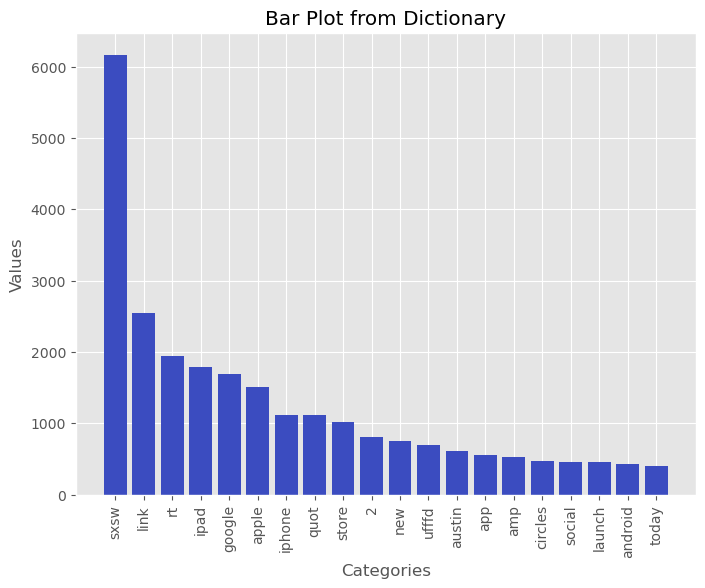

In [31]:
# Extract top 20 tokens and their values 
top_20 = FreqDist(X_train['tokenized_tweets'].explode()).most_common(20)
categories, values = zip(*top_20)

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(categories, values)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Plot from Dictionary')
plt.xticks(rotation=90)
plt.show()

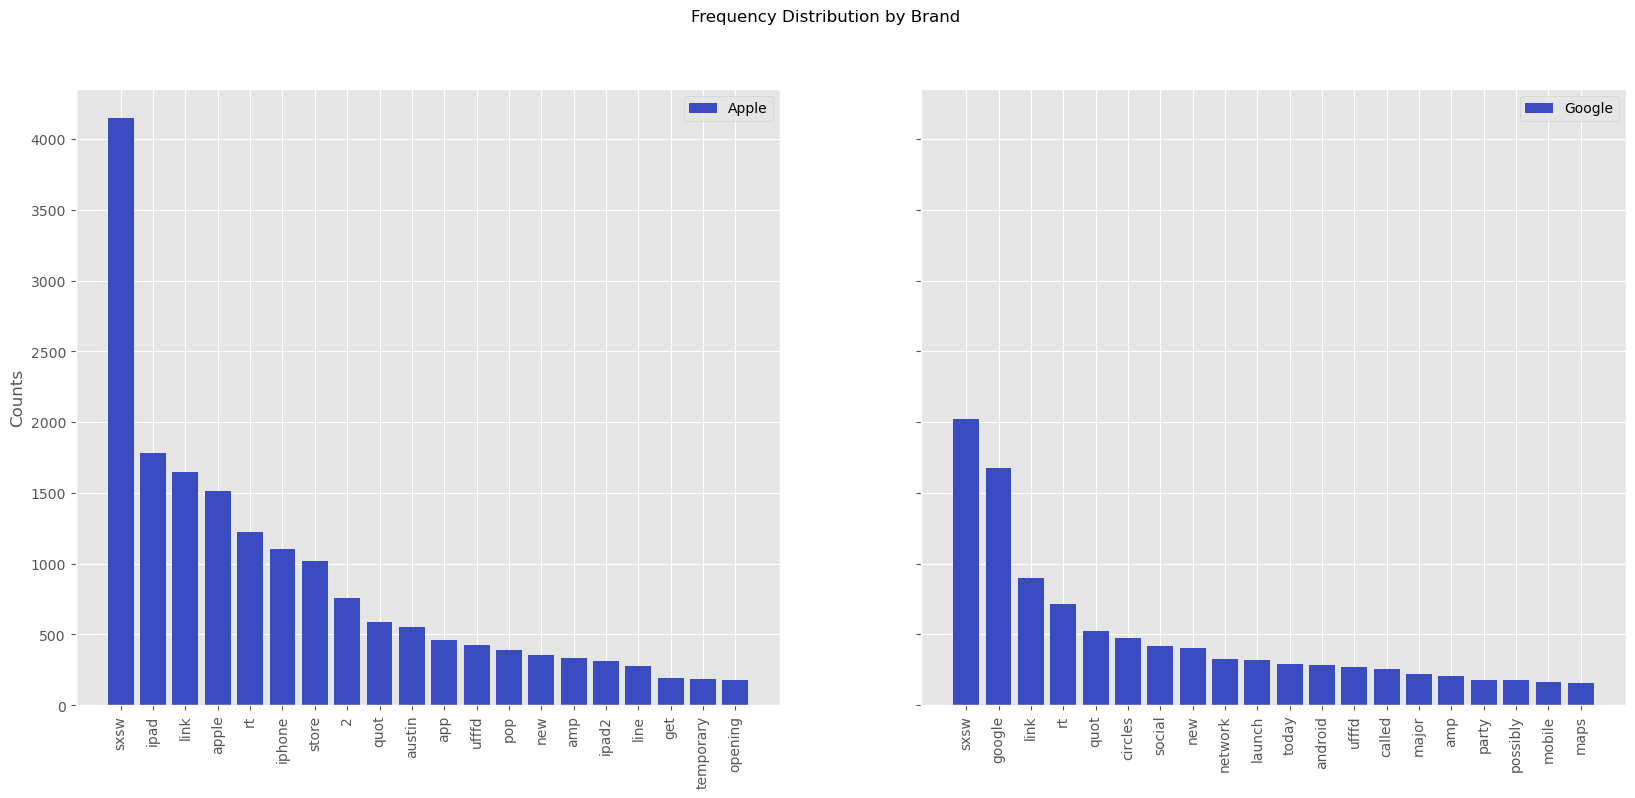

In [32]:
#check distirbution by regarding category
for_eda = pd.concat([X_train,y_train], axis= 1)
apple = for_eda[for_eda['brand_product'] == 'Apple']
google = for_eda[for_eda['brand_product'] == 'Google']

# Extract top 20 tokens and their values for apple brand
apple_top_20 = FreqDist(apple['tokenized_tweets'].explode()).most_common(20)
apple_categories, apple_values = zip(*apple_top_20)

# Extract top 20 tokens and their values for google brand
google_top_20 = FreqDist(google['tokenized_tweets'].explode()).most_common(20)
google_categories, google_values = zip(*google_top_20)

# Create a bar plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True) 
axes[0].bar(apple_categories, apple_values, label='Apple')
axes[1].bar(google_categories, google_values, label='Google')
axes[0].set_ylabel('Counts')
fig.suptitle('Frequency Distribution by Brand')
axes[0].set_xticks(range(len(apple_categories)))
axes[0].set_xticklabels(apple_categories, rotation=90) 
axes[1].set_xticks(range(len(google_categories)))
axes[1].set_xticklabels(google_categories, rotation=90)
# Set legends on the axes
axes[0].legend()
axes[1].legend()

plt.show()

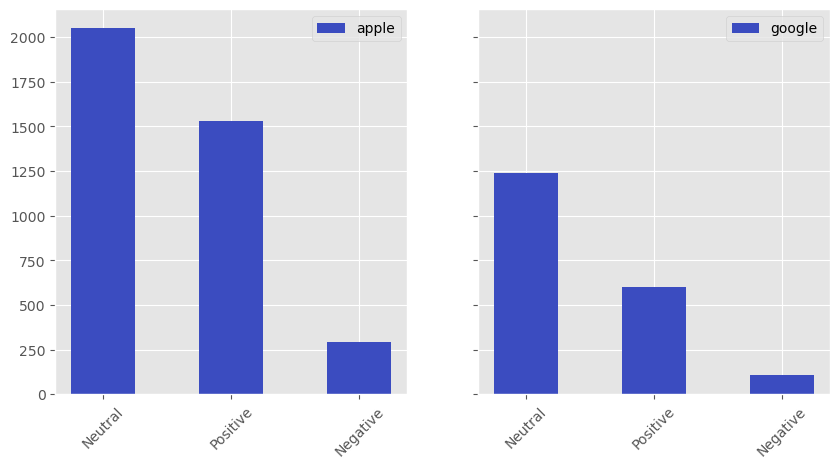

In [33]:
# Sentiments by brand
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize= (10, 5), sharey= True)
ax[0].bar(apple['emotion'].value_counts().index, apple['emotion'].value_counts(), width= .5, label='apple');
ax[1].bar(google['emotion'].value_counts().index, google['emotion'].value_counts(), width= .5, label= 'google')
ax[0].legend()
ax[1].legend()

for axis in ax:
    axis.tick_params(axis='x', rotation=45)
    
plt.show()

In [34]:
# Check token distribution based on emotion
positive_emotions_data = for_eda[for_eda['emotion'] == 'Positive']
negative_emotions_data = for_eda[for_eda['emotion'] == 'Negative']

# Extract top 20 tokens and their values for apple brand
positive_top_20 = FreqDist(positive_emotions_data['tokenized_tweets'].explode()).most_common(20)
positive_categories, positive_values = zip(*positive_top_20)

# Extract top 20 tokens and their values for google brand
negative_top_20 = FreqDist(negative_emotions_data['tokenized_tweets'].explode()).most_common(20)
negative_categories, negative_values = zip(*negative_top_20)

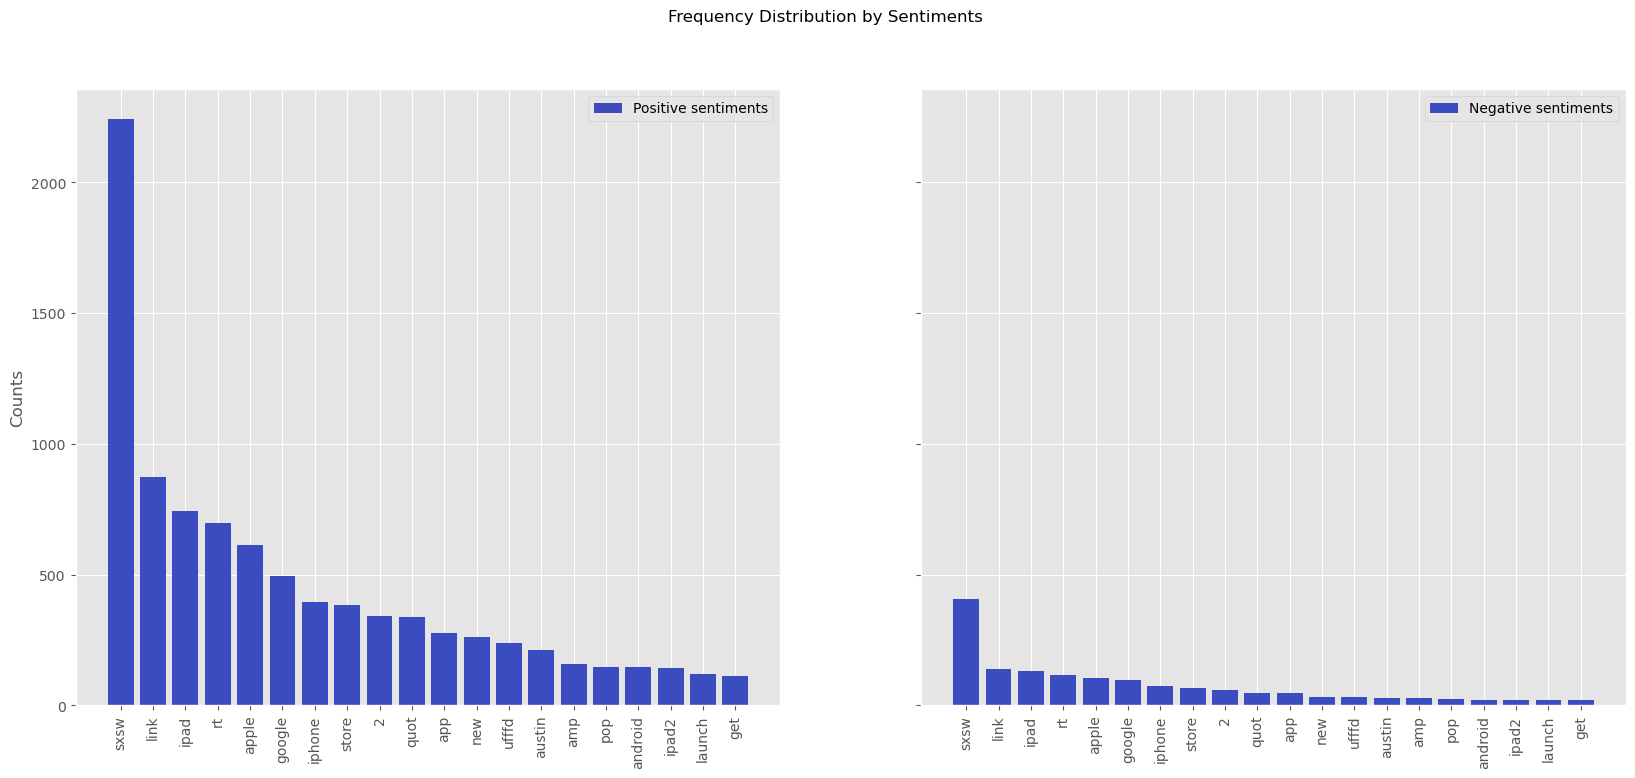

In [35]:
# Create a bar plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True) 
axes[0].bar(positive_categories, positive_values, label='Positive sentiments')
axes[1].bar(negative_categories, negative_values, label='Negative sentiments')
axes[0].set_ylabel('Counts')
fig.suptitle('Frequency Distribution by Sentiments')
axes[0].set_xticks(range(len(positive_categories)))
axes[0].set_xticklabels(positive_categories, rotation=90) 
axes[1].set_xticks(range(len(positive_categories)))
axes[1].set_xticklabels(positive_categories, rotation=90)
# Set legends on the axes
axes[0].legend()
axes[1].legend()

plt.show()

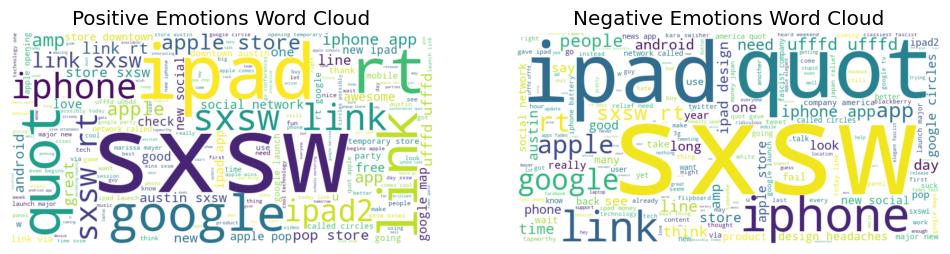

In [36]:
# Combine tokenized tweets into text strings
positive_text = ' '.join(positive_emotions_data['tokenized_tweets'].explode())
negative_text = ' '.join(negative_emotions_data['tokenized_tweets'].explode())

# Create word clouds for positive and negative emotions
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plot word clouds
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Emotions Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Emotions Word Cloud')
plt.axis('off')

plt.show()

# Vectorization 

##### Using RegexpTokenizer and TfidfVectorizer

In [37]:
# Instantiate vectorizer
stops = stopwords.words('english') + list(punctuation)
tfidf_regex = TfidfVectorizer(
    tokenizer = lambda text: RegexpTokenizer(r"\b\w+(?:'\w+)?\b").tokenize(text),
    stop_words= stops,
    max_df = .8,
    max_features = 5000
                    )

# Fit the vectorizer on X_train["text"] and transform it
X_train_tfidf_regex = tfidf_regex.fit_transform(X_train['cleaned_tweet'])

/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [39]:
X_train_tfidf_regex

<5826x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 58933 stored elements in Compressed Sparse Row format>

##### Using Lemmatizer and TfidfVectorizer

In [56]:
# Tokenization and Lemmatization function
def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)  # Tokenization
    # Instantiate WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization
    return lemmatized_tokens

In [60]:
# Initialize TfidfVectorizer with lemmatization
tfidf_lem = TfidfVectorizer(
    tokenizer = tokenize_and_lemmatize,
    stop_words= stops,
    max_df = .8,
    max_features = 5000
                    )

# Fit the vectorizer on X_train["text"] and transform it
X_train_tfidf_lem = tfidf_lem.fit_transform(X_train['cleaned_tweet'])

/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [40]:
# Visually inspect X_train_tfidf_regex
X_train_tfidf_regex = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf_regex, 
                                                        columns=tfidf_regex.get_feature_names_out())
X_train_tfidf_regex

,0,000,00pm,03,1,10,100,100s,101,106,...,zazzlesxsw,zazzlsxsw,zing,zip,zms,zombies,zomg,zone,zoom,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Visually inspect X_train_tfidf_lem
X_train_tfidf_lem = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf_lem, 
                                                        columns=tfidf_lem.get_feature_names_out())
X_train_tfidf_lem

,'80s-themed,'85,'after,'boolean,'checkout,'circles,'closed,'congo,'d,'designing,...,zoom,zuckerberg,zuckerberg.\n,zynga,zzzs,|fyi,||,~150\ufffd\ufffd_,~150mm,~150mm\ufffd\ufffd_
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### OneHotEncode brand_product column

In [41]:
#Instantiate class
ohe = OneHotEncoder()

#Fit transform X_train's brand_product column
brand_product_ohe = ohe.fit_transform(X_train[['brand_product']])
brand_product_ohe = pd.DataFrame.sparse.from_spmatrix(brand_product_ohe, 
                                                      columns= ohe.get_feature_names_out())
brand_product_ohe

,brand_product_Apple,brand_product_Google
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0
...,...,...
5821,1.0,0.0
5822,1.0,0.0
5823,1.0,0.0
5824,1.0,0.0


In [62]:
# Append to X_train_tfidf_regex & X_train_tfidf_lem
X_train_final_regex = pd.concat([X_train_tfidf_regex, brand_product_ohe], axis= 1)
X_train_final_lem = pd.concat([X_train_tfidf_lem, brand_product_ohe], axis= 1)

# Baseline Model

### Naive Bayes

##### regex data

In [43]:
# Instantiate a MultinomialNB classifier with default params
baseline_nb = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv_nb = cross_validate(baseline_nb, X_train_final_regex, y_train)['test_score']
baseline_cv_nb

array([0.6329331 , 0.64034335, 0.63433476, 0.61030043, 0.65579399])

##### lemmitized data

In [64]:
# Instantiate a MultinomialNB classifier with default params
baseline_nb = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv_nb = cross_validate(baseline_nb, X_train_final_lem, y_train)['test_score']
baseline_cv_nb

array([0.62778731, 0.64463519, 0.6223176 , 0.61373391, 0.65150215])

### Decision Tree

##### regex data

In [44]:
# Instatiate class
baseline_dt = DecisionTreeClassifier()
# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv_dt = cross_validate(baseline_dt, X_train_final_regex, y_train)['test_score']
baseline_cv_dt

array([0.58576329, 0.61030043, 0.62145923, 0.56566524, 0.5751073 ])

##### lemmatized data

In [65]:
# Instatiate class
baseline_dt = DecisionTreeClassifier()
# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv_dt = cross_validate(baseline_dt, X_train_final_lem, y_train)['test_score']
baseline_cv_dt

array([0.5806175 , 0.60858369, 0.60772532, 0.57424893, 0.58283262])

# Addressing Class Imbalance (SMOTE)

In [45]:
# Encode y_train using ordinal encoder
ord_encode = OrdinalEncoder()

# Fit and transform y_train
y_train_encoded = ord_encode.fit_transform(y_train.values.reshape(-1, 1))
y_train_encoded

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [46]:
ord_encode.categories_

[array(['Negative', 'Neutral', 'Positive'], dtype=object)]

In [47]:
y_train.reset_index()

,index,emotion
0,4226,Neutral
1,5953,Neutral
2,2532,Neutral
3,2481,Positive
4,2652,Positive
...,...,...
5821,905,Positive
5822,5192,Positive
5823,3980,Neutral
5824,235,Neutral


##### regex

In [48]:
# Instantiate class
smote = SMOTE()

# Fit and resample X_train data
X_train_final_regex_resampled, y_train_resampled = smote.fit_resample(X_train_final_regex.reset_index(), 
                                                                      y_train_encoded)

/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


##### lemmatised

In [66]:
# Instantiate class
smote = SMOTE()

# Fit and resample X_train data
X_train_final_lem_resampled, y_train_resampled = smote.fit_resample(X_train_final_lem.reset_index(), 
                                                                    y_train_encoded)

/Users/dave/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [49]:
smote.get_feature_names_out()

array(['index', '0', '000', ..., 'zuckerberg', 'brand_product_Apple',
       'brand_product_Google'], dtype=object)

In [50]:
# Convert back to sparse matrix 
X_train_final_regex_resampled = csr_matrix(X_train_final_regex_resampled)

# Reattach column names to the sparse matrix
X_train_final_regex_resampled = pd.DataFrame.sparse.from_spmatrix(X_train_final_regex_resampled, 
                                                            columns=smote.get_feature_names_out())
X_train_final_regex_resampled = X_train_final_regex_resampled.set_index('index')

In [67]:
# Convert back to sparse matrix 
X_train_final_lem_resampled = csr_matrix(X_train_final_lem_resampled)

# Reattach column names to the sparse matrix
X_train_final_lem_resampled = pd.DataFrame.sparse.from_spmatrix(X_train_final_lem_resampled, 
                                                            columns=smote.get_feature_names_out())
X_train_final_lem_resampled = X_train_final_lem_resampled.set_index('index')

### Modelling on resampled data 

#### Naive Bayes

##### regex

In [51]:
# Naive bayes

# Instantiate a MultinomialNB classifier with default params
baseline_nb = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv_nb = cross_validate(baseline_nb, X_train_final_regex_resampled, y_train_resampled)['test_score']
baseline_cv_nb

array([0.72129489, 0.73444613, 0.7455741 , 0.77946383, 0.78603945])

##### lemmatized

In [68]:
# Naive bayes

# Instantiate a MultinomialNB classifier with default params
baseline_nb = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv_nb = cross_validate(baseline_nb, X_train_final_lem_resampled, y_train_resampled)['test_score']
baseline_cv_nb

array([0.72180071, 0.73748103, 0.73849267, 0.76783005, 0.7814871 ])

#### Decision Tree

##### regex

In [52]:
# Instatiate class
baseline_dt = DecisionTreeClassifier()
# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv_dt = cross_validate(baseline_dt, X_train_final_regex_resampled, y_train_resampled)['test_score']
baseline_cv_dt

array([0.56803237, 0.70864947, 0.70308548, 0.72635306, 0.71876581])

##### lemmatized

In [69]:
# Instatiate class
baseline_dt = DecisionTreeClassifier()
# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv_dt = cross_validate(baseline_dt, X_train_final_lem_resampled, y_train_resampled)['test_score']
baseline_cv_dt

array([0.60242792, 0.7035913 , 0.69246333, 0.75063227, 0.72230653])

#### Random Forest

##### regex

In [53]:
# Random Forest
baseline_rf = RandomForestClassifier()

baseline_cv_rf = cross_validate(baseline_rf, X_train_final_regex_resampled, y_train_resampled)['test_score']
baseline_cv_rf

array([0.67627719, 0.75518462, 0.77693475, 0.85685382, 0.84623166])

##### lemmatized

In [70]:
# Random Forest
baseline_rf = RandomForestClassifier()

baseline_cv_rf = cross_validate(baseline_rf, X_train_final_lem_resampled, y_train_resampled)['test_score']
baseline_cv_rf

array([0.68487607, 0.76884168, 0.77035913, 0.8533131 , 0.85078402])

#### XGBoost

##### regex

In [74]:
# Instantiate the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class= len(y_train.value_counts()), seed=42)

baseline_cv_xgb = cross_validate(xgb_clf, X_train_final_regex_resampled, y_train_resampled)['test_score']
baseline_cv_xgb

array([0.61861406, 0.76024279, 0.77035913, 0.84825493, 0.83712696])

##### lemmatized

In [73]:
# Instantiate the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class= len(y_train.value_counts()), seed=42)

baseline_cv_xgb = cross_validate(xgb_clf, X_train_final_lem_resampled, y_train_resampled)['test_score']
baseline_cv_xgb

array([0.61456753, 0.75872534, 0.77389985, 0.85584219, 0.85078402])

In [ ]:
#Use lematization & Stemming within the tokenizer of TfidfVectorizer
#OneHot Encode brand_product
#Add AdaBoost/XGBoost
#GridSearch Best params
#Utilise Pipeline to organise workflow

In [ ]:
# Reccomendation

Can sentiment analysis of Twitter data accurately identify areas for improvement in Google and Apple products and services?